In [136]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import glob
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [53]:
f = open ( "mesh_input.txt" , 'r')
input_data = []
input_data = [line.split() for line in f]
mesh_input = np.array([])
mesh_input.resize((21,21))
for i in range(len(input_data)):
    col = int(input_data[i][0])
    row = int(input_data[i][1])
    val = float(input_data[i][2])
    mesh_input[col][row] = val

In [58]:
filename_all = glob.glob("traindata/*.txt")
list_in = []
list_out = []
for filename in filename_all:
    para = filename.split("_")
    D = para[1]
    K = para[2]
    t = para[3].split(".txt")[0]
    f = open ( filename , 'r')
    row_data = []
    row_data = [line.split() for line in f]

    matrix_output = np.array([])
    matrix_output.resize((1,21,21))
    matrix_input = np.array([])
    matrix_input.resize((4,21,21))
    
    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix_output[0][col][row] = val
        
#     matrix_input[0]=-1
#     matrix_input[0,20,1:19] = 2/3
#     matrix_input[0,:,0] = 0
#     matrix_input[0,:,20] = 0
#     matrix_input[0,0,:] = 0
    matrix_input[0] = np.copy(mesh_input)
    matrix_input[1] = D
    matrix_input[2] = K
    matrix_input[3] = t
    list_in.append(matrix_input)
    list_out.append(matrix_output)
arr_in = np.array(list_in)
arr_out = np.array(list_out)

In [59]:
train_in = []
train_out = []
test_in = []
test_out = []
for i in range(400):
    arr_train_in = np.copy(arr_in[(5*i):(5*i+5),:,:,:])
    ten_train_in = torch.from_numpy(arr_train_in)
    train_in.append(ten_train_in)
    
    arr_train_out = np.copy(arr_out[(5*i):(5*i+5),:,:,:]) 
    ten_train_out = torch.from_numpy(arr_train_out)
    train_out.append(ten_train_out)
    
for i in range(50):
    arr_test_in = np.copy(arr_in[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_in = torch.from_numpy(arr_test_in)
    test_in.append(ten_test_in)
    
    arr_test_out = np.copy(arr_out[(5*i+2000):(5*i+2005),:,:,:])
    ten_test_out = torch.from_numpy(arr_test_out)
    test_out.append(ten_test_out)

In [67]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


# def to_img(x):
#     x = 0.5 * (x + 1)
#     x = x.clamp(0, 1)
#     x = x.view(x.size(0), 1, 28, 28)
#     return x


num_epochs = 15
batch_size = 5
learning_rate = 1e-3

# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# dataset = MNIST('./data', transform=img_transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 16, 3, stride=2, padding=0),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 2, stride=2),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2),  # b, 1, 21, 21
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

for epoch in range(num_epochs):
    for i in range(len(train_in)):
        img = train_in[i]
        img = img.float()
        ground_truth = train_out[i]
        ground_truth = ground_truth.float()
        img = Variable(img).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, ground_truth)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
#         pic = to_img(output.cpu().data)
        save_image(output, './dc_img/image_{}.png'.format(epoch))

# torch.save(model.state_dict(), './conv_autoencoder.pth')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/15], loss:0.0112
epoch [2/15], loss:0.0059
epoch [3/15], loss:0.0034
epoch [4/15], loss:0.0016
epoch [5/15], loss:0.0012
epoch [6/15], loss:0.0009
epoch [7/15], loss:0.0008
epoch [8/15], loss:0.0007
epoch [9/15], loss:0.0007
epoch [10/15], loss:0.0007
epoch [11/15], loss:0.0007
epoch [12/15], loss:0.0007
epoch [13/15], loss:0.0007
epoch [14/15], loss:0.0007
epoch [15/15], loss:0.0007


In [71]:
if not os.path.exists('./test_img'):
    os.mkdir('./test_img')
for i in range(len(test_in)):
    img = test_in[i]
    img = test_in[i].float()
    ground_truth = test_out[i]
    ground_truth = ground_truth.float()
    img = Variable(img).to(device)

    output = model(img)

    loss = criterion(output, ground_truth)

    save_image(output, './test_img/image_{}.png'.format(i))
    save_image(ground_truth, './test_img/ground_truth_{}.png'.format(i))



In [108]:
model_output = []
for i in range(len(test_in)):
    img = test_in[i]
    img = test_in[i].float()
    ground_truth = test_out[i]
    ground_truth = ground_truth.float()
    img = Variable(img).to(device)

    output = model(img)
    model_output.append(output)

In [131]:
if not os.path.exists('./test_txt'):
    os.mkdir('./test_txt')

for index in range(50):
    arr_in = test_in[index]
    arr_out = model_output[index].detach()
    array_in = arr_in.numpy()[:, :, :, :]
    array_out = arr_out.numpy()[:, :, :, :]
    
    for piece_index in range(5):
        D = array_in[piece_index,1,1,1]
        k = array_in[piece_index,2,1,1]
        t = array_in[piece_index,3,1,1]

        write_array = array_out[piece_index,:,:,:].reshape(21,21)

        dir_name = "./test_txt/"
        filename = dir_name + "mesh_"+str(int(D))+"_"+str(int(k))+"_"+str(t)+".txt"
        text = ""
        f = open(filename,"w")
        for i in range(21):
            for j in range (21):
                text = text + str(i) + " " + str(j) + " " + str(write_array[i][j]) +"\n"

        f.write(text)                                    
        f.close()

In [124]:
def readFileasArray(filename):
    f = open ( filename , 'r')
    row_data = []
    row_data = [line.split() for line in f]

    matrix = np.array([])
    matrix.resize((21,21))

    for i in range(len(row_data)):
        col = int(row_data[i][0])
        row = int(row_data[i][1])
        val = float(row_data[i][2])
        matrix[col][row] = val
    return matrix

## t changed 

In [156]:
list_t = []
list_t.append(readFileasArray("test_txt/mesh_1_3_0.0.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_1.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_3.6.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_5.4.txt"))
list_t.append(readFileasArray("test_txt/mesh_1_3_9.9.txt"))

list_r = []
list_r.append(readFileasArray("traindata/mesh_1_3_0.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_1.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_3.6.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_5.4.txt"))
list_r.append(readFileasArray("traindata/mesh_1_3_9.9.txt"))

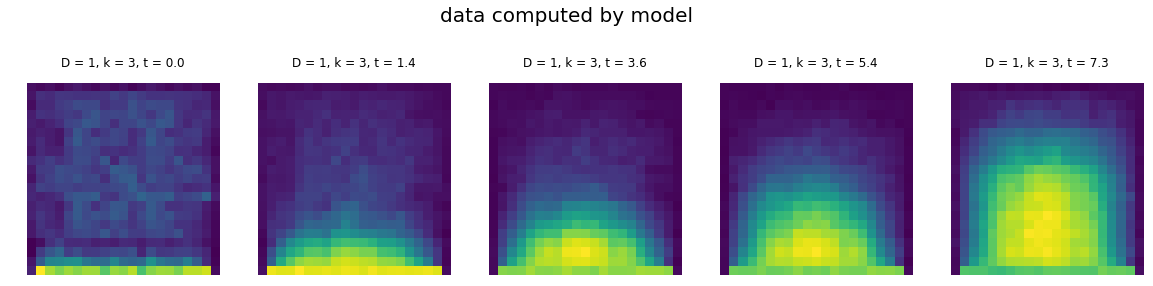

In [154]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    ax[i].matshow(list_t[i])
    ax[i].axis('off')
ax[0].set_title("D = 1, k = 3, t = 0.0")
ax[1].set_title("D = 1, k = 3, t = 1.4")
ax[2].set_title("D = 1, k = 3, t = 3.6")
ax[3].set_title("D = 1, k = 3, t = 5.4")
ax[4].set_title("D = 1, k = 3, t = 7.3")

fig.suptitle("data computed by model", fontsize=20)
plt.show()

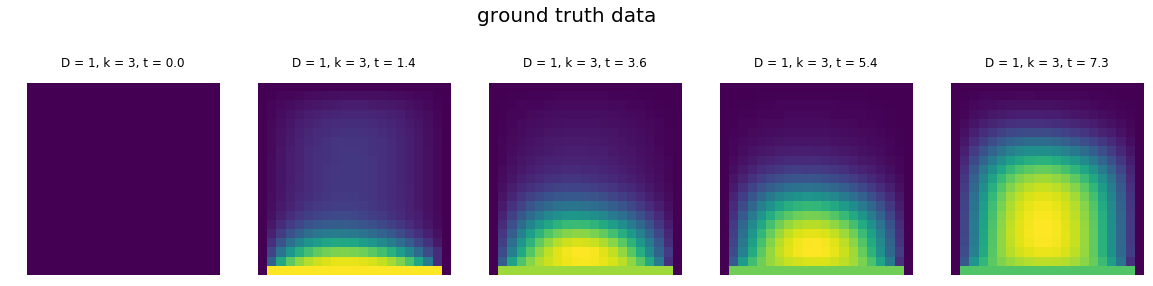

In [157]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
for i in range(5):
    ax[i].matshow(list_r[i])
    ax[i].axis('off')
ax[0].set_title("D = 1, k = 3, t = 0.0")
ax[1].set_title("D = 1, k = 3, t = 1.4")
ax[2].set_title("D = 1, k = 3, t = 3.6")
ax[3].set_title("D = 1, k = 3, t = 5.4")
ax[4].set_title("D = 1, k = 3, t = 7.3")

fig.suptitle("ground truth data", fontsize=20)
plt.show()